In [131]:
# Get info of One Model evals (without fine-tuned G-Retriever)

import os
import json

path = "Model Outpus & Evaluation/One Model Evaluation/"
files_to_data = dict()

for f_name in os.listdir(path):
    with open(f"{path}/{f_name}", 'r') as f:
        data = f.readlines()
        data = [json.loads(x) for x in data]
    
    files_to_data[f_name] = data

unique_files = [x[:-7] for x in list(files_to_data.keys())]
unique_files = list(set(unique_files))

In [132]:
import pandas as pd
import re

rag_df = pd.DataFrame()
g_retr_df = pd.DataFrame()
ft_df = pd.DataFrame()

f_name_to_scores = dict()

for f_name in unique_files:
    scores_list = list()
    for q_id in range(len(files_to_data[f_name+ '1.jsonl'])):
        score = list()
        for i in range(1, 4):
            f_name_with_number = f"{f_name}{i}.jsonl"
            score.append(
                int(files_to_data[f_name_with_number][q_id]['score'])
            )
        scores_list.append(
            sorted(score)[1]
        )
    f_name_to_scores[f_name] = scores_list

    count = re.findall(r"\d+", f_name)[0]

    if "FT" in f_name:
        ft_df[str(count)] = scores_list
    elif "RAG" in f_name:
        rag_df[str(count)] = scores_list
    else:
        g_retr_df[str(count)] = scores_list

In [133]:
sorted_vals = list(map(str,sorted(map(int, g_retr_df.columns))))

rag_df = rag_df.reindex(sorted_vals, axis=1)
g_retr_df = g_retr_df.reindex(sorted_vals, axis=1)

rag_df['category'] = ['syntax'] * 140 + ['dependencies'] * 135 + ['meta'] * 50
rag_df['type'] = ['RAG']*325

g_retr_df['category'] = ['syntax'] * 140 + ['dependencies'] * 135 + ['meta'] * 50
g_retr_df['type'] = ['G-Retriever']*325

ft_df['category'] = ['syntax'] * 56 + ['dependencies'] * 54 + ['meta'] * 20

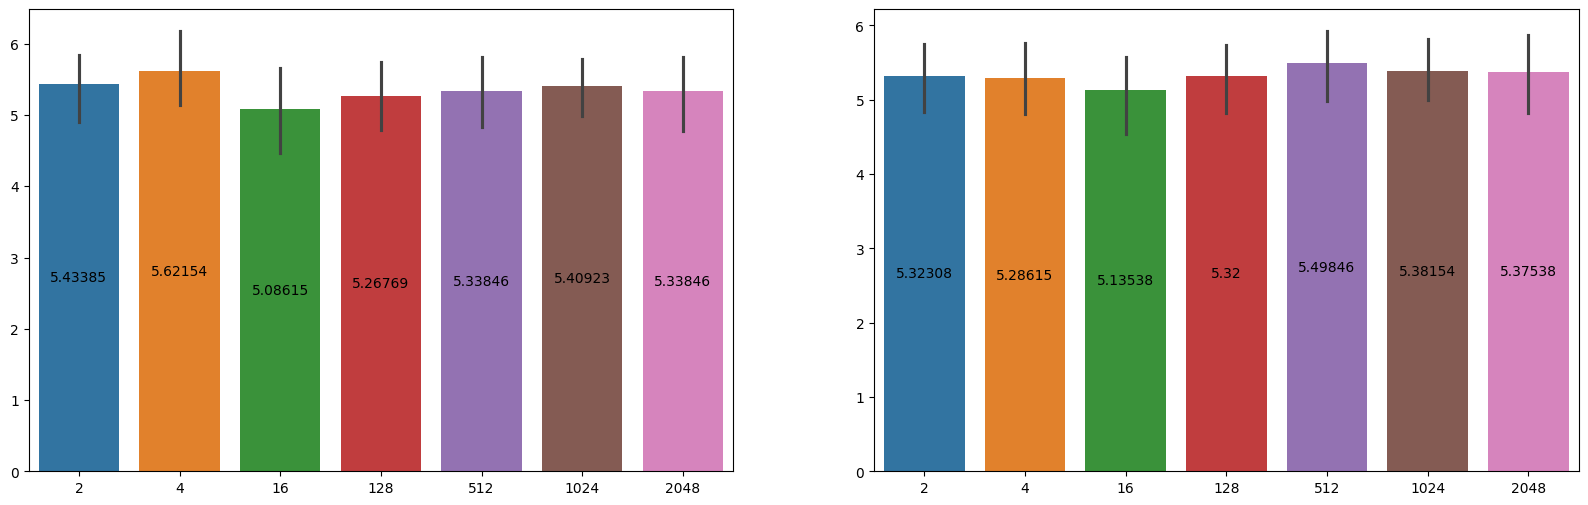

In [70]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,2, figsize=(20, 6))

ax1 = sns.barplot(g_retr_df, errorbar=('ci', 100), ax=ax[0])
for con in ax1.containers:
    ax1.bar_label(con, label_type='center')

ax2 = sns.barplot(rag_df, errorbar=('ci', 100), ax=ax[1])
for con in ax2.containers:
    ax2.bar_label(con, label_type='center')

             type category variable  value
0             RAG   syntax        2      6
1             RAG   syntax        2      8
2             RAG   syntax        2      9
3             RAG   syntax        2      4
4             RAG   syntax        2      4
...           ...      ...      ...    ...
4545  G-Retriever     meta     2048      2
4546  G-Retriever     meta     2048      3
4547  G-Retriever     meta     2048      9
4548  G-Retriever     meta     2048      8
4549  G-Retriever     meta     2048      4

[4550 rows x 4 columns]


<Axes: xlabel='variable', ylabel='value'>

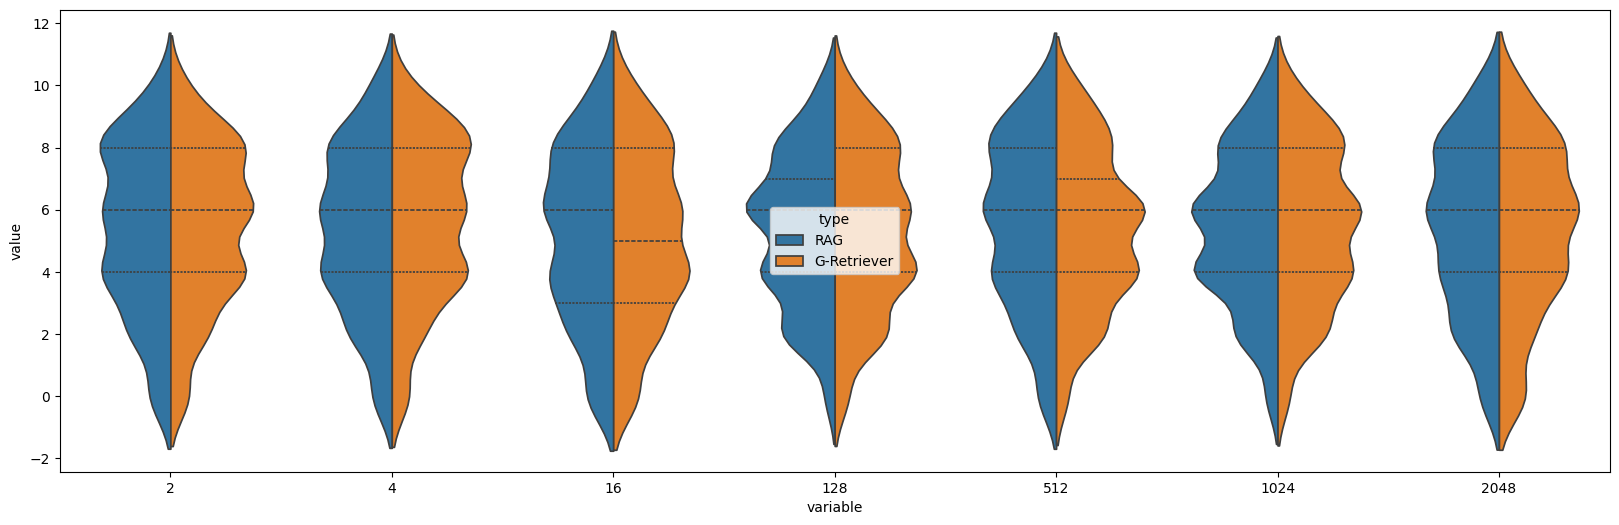

In [103]:
df_full = pd.concat([rag_df, g_retr_df], axis=0)
df_full = pd.melt(df_full, id_vars=['type', 'category'])

print(df_full)

fig, ax = plt.subplots(1, 1, figsize=(20, 6))
sns.violinplot(df_full,
               x='variable',
               y='value',
               hue="type",
               split=True, inner='quart', gridsize=50, ax=ax)

2         4        16       128       512  \
type        category                                                         
G-Retriever dependencies  4.696296  4.903704  4.370370  4.422222  4.629630   
            meta          6.380000  6.340000  5.920000  6.140000  6.200000   
            syntax        5.807143  6.057143  5.478571  5.771429  5.714286   
RAG         dependencies  4.585185  4.644444  4.355556  4.592593  4.740741   
            meta          6.380000  6.280000  6.220000  6.200000  6.200000   
            syntax        5.657143  5.550000  5.500000  5.707143  5.978571   

                              1024      2048  
type        category                          
G-Retriever dependencies  4.962963  4.903704  
            meta          5.860000  6.060000  
            syntax        5.678571  5.500000  
RAG         dependencies  4.585185  4.896296  
            meta          5.860000  6.240000  
            syntax        5.978571  5.528571

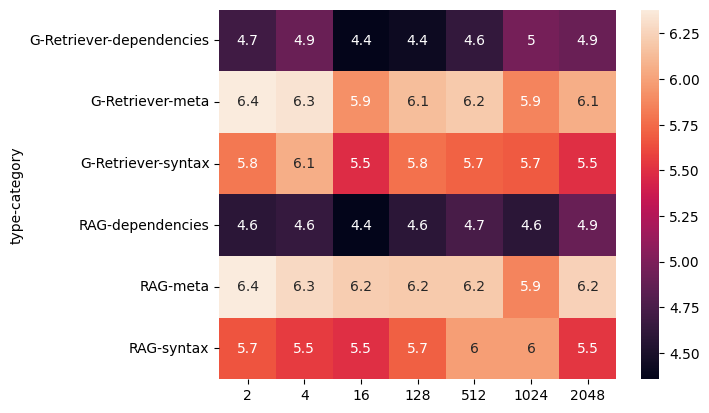

In [ ]:
sns.heatmap(
    pd.concat([rag_df, g_retr_df]).groupby(['type', 'category']).mean(),
    annot=True
)

pd.concat([rag_df, g_retr_df]).groupby(['type', 'category']).mean()

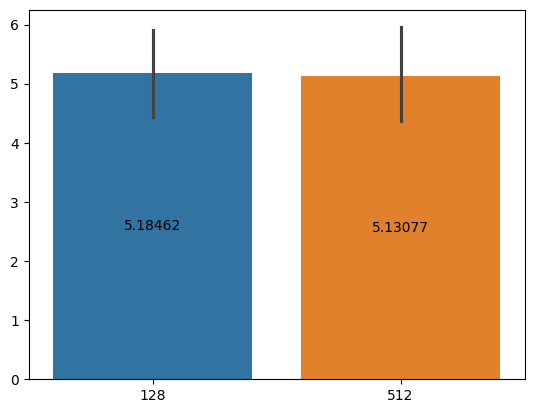

In [125]:
ax1 = sns.barplot(ft_df, errorbar=('ci', 100))
for con in ax1.containers:
    ax1.bar_label(con, label_type='center')

<Axes: ylabel='category'>

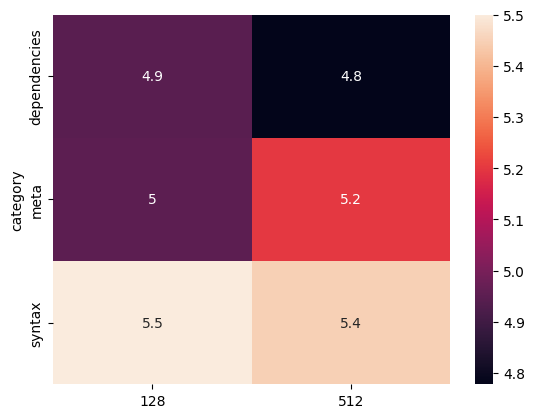

In [135]:
sns.heatmap(
    ft_df.groupby('category').mean(),
    annot=True
)